<a href="https://colab.research.google.com/github/virdi/TEMPOviz/blob/main/TEMPO_SyntheticEarlyAdopters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quick TEMPO Synthetic Data Visualizer

    author: Barron H. Henderson
    date: 2020-11-20
    contributors: James East and Shannon Koplitz

This notebook is designed to download remote TEMPO data, select data based on QA flags, and make a map.

# Prepare system

## Install Libraries
* Adding a netCDF4 reader and overlay plotter
* these are not standard on Google Colab, but are easy to add

In [ ]:
pip install netcdf4 cftime pycno

     |████████████████████████████████| 4.7MB 11.6MB/s 
     |████████████████████████████████| 317kB 57.7MB/s 


## Importing Libraries

* `os`, `datetime`, `urllib` are standard python libraries
* `numpy` and `matplotlib` are standard with Google Colab
* `netCDF4` and `pycno` were added above

In [ ]:
import os
from urllib.request import urlopen, urlretrieve
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import cftime
import pycno
from urllib.request import urlopen
import json
import pandas as pd

## Hide Warnings

* Some commands report warngings that are expected and handled.
* This command hides them, so you don't have to worry.

In [ ]:
import warnings
warnings.simplefilter('ignore')

## Enter AQS Username and Key (optional)

* If you have an AQS username, enter it here.
* If not, you will use archived AQS data.

Tutorial username and password:
  `username = 'test@aqs.api'`
  `userkey = 'test'`


In [ ]:
# The user credentials that will be used to authenticate access to the data
import getpass
username = input("AQS API username:")
userkey = getpass.getpass("AQS API password:")

AQS API username:barronh@gmail.com
AQS API password:··········


# Get data all filepaths for a day

Data is currently on an HTTP server, which won't likely be the long-term delivery mechanism. The data root (`droot`) is a url you can navigate to select data.

This notebook selects data using "Web Scraping" to automatically select files. 

* The date (here 2013-07-01) is used to get the file index HTML
* The HTML result is parsed to find links.
* The links are converted to local filepaths.
* Next, we separate nitrogen dioxide (NO2) and formaldehyde (HCHO) into groups.
* Finally, print the NO2 filepaths for review.

In [ ]:
date = cftime.num2pydate(0, 'days since 2020-07-11')
droot = 'https://geo.nsstc.nasa.gov/SPoRT/outgoing/arn/testdata/'
foldertmpl = f'{droot}/%Y%m/%d/'
folderurl = date.strftime(foldertmpl)
index = urlopen(folderurl).read().decode()
prefix = '<tr><td class="n"><a href="'
allfilepaths = sorted([
  line[len(prefix):].split('"')[0]
  for line in index.split('\n') if line.startswith(prefix)
])

In [ ]:
no2filepaths = [path for path in allfilepaths if 'NO2' in path]
hchofilepaths = [path for path in allfilepaths if 'HCHO' in path]

In [ ]:
no2filepaths

['TEMPO_NO2_L2_V01_20200711T001759Z_S000G04.nc',
 'TEMPO_NO2_L2_V01_20200711T002359Z_S000G05.nc',
 'TEMPO_NO2_L2_V01_20200711T002959Z_S000G06.nc',
 'TEMPO_NO2_L2_V01_20200711T003559Z_S000G07.nc',
 'TEMPO_NO2_L2_V01_20200711T004158Z_S000G08.nc',
 'TEMPO_NO2_L2_V01_20200711T004758Z_S000G09.nc',
 'TEMPO_NO2_L2_V01_20200711T005358Z_S000G10.nc',
 'TEMPO_NO2_L2_V01_20200711T012959Z_S001G06.nc',
 'TEMPO_NO2_L2_V01_20200711T013559Z_S001G07.nc',
 'TEMPO_NO2_L2_V01_20200711T014158Z_S001G08.nc',
 'TEMPO_NO2_L2_V01_20200711T014758Z_S001G09.nc',
 'TEMPO_NO2_L2_V01_20200711T015358Z_S001G10.nc',
 'TEMPO_NO2_L2_V01_20200711T023559Z_S002G07.nc',
 'TEMPO_NO2_L2_V01_20200711T024158Z_S002G08.nc',
 'TEMPO_NO2_L2_V01_20200711T024758Z_S002G09.nc',
 'TEMPO_NO2_L2_V01_20200711T025358Z_S002G10.nc',
 'TEMPO_NO2_L2_V01_20200711T100000Z_S002G01.nc',
 'TEMPO_NO2_L2_V01_20200711T100600Z_S002G02.nc',
 'TEMPO_NO2_L2_V01_20200711T101200Z_S002G03.nc',
 'TEMPO_NO2_L2_V01_20200711T101759Z_S002G04.nc',
 'TEMPO_NO2_L2_V01_2

# Create a TEMPO Map for one Scan

* We are going to download a single scan of the US
  * A scan is one view of the entire field of view.
  * The scan is made of granules that represent a roughly South to North slice.
* Then, we are going to make
  * a static map of tropospheric columns
  * add animation
  * look at the air mass factor

## Subset filepaths

* Downloading is slow, so in this step we take just a single scan
  * each scan (S00?) has 10 files (G01..G10)
  * so 10 files represents one scan
* S010 starts at 18Z or 13 Eastern
* After subsetting, print file names for user review.


In [ ]:
# For testing use only the 6th pass over the US
filepaths = [path for path in no2filepaths if 'S010' in path]
filepaths

['TEMPO_NO2_L2_V01_20200711T180000Z_S010G01.nc',
 'TEMPO_NO2_L2_V01_20200711T180600Z_S010G02.nc',
 'TEMPO_NO2_L2_V01_20200711T181200Z_S010G03.nc',
 'TEMPO_NO2_L2_V01_20200711T181759Z_S010G04.nc',
 'TEMPO_NO2_L2_V01_20200711T182359Z_S010G05.nc',
 'TEMPO_NO2_L2_V01_20200711T182959Z_S010G06.nc',
 'TEMPO_NO2_L2_V01_20200711T183559Z_S010G07.nc',
 'TEMPO_NO2_L2_V01_20200711T184158Z_S010G08.nc',
 'TEMPO_NO2_L2_V01_20200711T184758Z_S010G09.nc',
 'TEMPO_NO2_L2_V01_20200711T185358Z_S010G10.nc']

## Download each file you don't have

The files are all publicly accessible via http download. The urls can be constructed by combining the earlier web address with the file names. For each file name, the file will be downloaded.

* `os.path.exists` is used to check if the file exists. If it does, the file is skipped.
* This should only download files that you don't already have.
* If you cancel (ctrl+c) during a download...
  * the file will exist but will not be complete.
  * You would then need to delete the file manually and re-run.


In [ ]:
def download(filepaths):
  for filepath in filepaths:
    if not os.path.exists(filepath):
      print(filepath, '...', end='', flush=True)
      urlretrieve(folderurl + filepath, filepath)
    else:
      print(filepath, 'already downloaded', end='', flush=True)
    print('.')

In [ ]:
%%time
download(filepaths)

TEMPO_NO2_L2_V01_20200711T180000Z_S010G01.nc ....
TEMPO_NO2_L2_V01_20200711T180600Z_S010G02.nc ....
TEMPO_NO2_L2_V01_20200711T181200Z_S010G03.nc ....
TEMPO_NO2_L2_V01_20200711T181759Z_S010G04.nc ....
TEMPO_NO2_L2_V01_20200711T182359Z_S010G05.nc ....
TEMPO_NO2_L2_V01_20200711T182959Z_S010G06.nc ....
TEMPO_NO2_L2_V01_20200711T183559Z_S010G07.nc ....
TEMPO_NO2_L2_V01_20200711T184158Z_S010G08.nc ....
TEMPO_NO2_L2_V01_20200711T184758Z_S010G09.nc ....
TEMPO_NO2_L2_V01_20200711T185358Z_S010G10.nc ....
CPU times: user 3.52 s, sys: 2.76 s, total: 6.28 s
Wall time: 2min 18s


## Display File Structure

* This is just FYI for further development.
* NetCDF4 has a root group and other groups
* This prints the dimensions and variables for each group.

In [ ]:
def showgroup(grp, parentkey='', out=None):
  if out is None:
    out = {}
  keys = {k: v.dimensions for k, v in grp.variables.items()}
  if len(keys)>0:
    out[parentkey] = keys
  for sgrpk, sgrp in grp.groups.items():
    showgroup(sgrp, parentkey=f'{parentkey}/{sgrpk}', out=out)
  return out

In [ ]:
f = Dataset(filepaths[0])
showgroup(f)

{'': {'mirror_step': ('mirror_step',), 'xtrack': ('xtrack',)},
 '/geolocation': {'latitude': ('mirror_step', 'xtrack'),
  'latitude_bounds': ('mirror_step', 'xtrack', 'corner'),
  'longitude': ('mirror_step', 'xtrack'),
  'longitude_bounds': ('mirror_step', 'xtrack', 'corner'),
  'relative_azimuth_angle': ('mirror_step', 'xtrack'),
  'solar_azimuth_angle': ('mirror_step', 'xtrack'),
  'solar_zenith_angle': ('mirror_step', 'xtrack'),
  'time': ('mirror_step',),
  'viewing_azimuth_angle': ('mirror_step', 'xtrack'),
  'viewing_zenith_angle': ('mirror_step', 'xtrack')},
 '/product': {'main_data_quality_flag': ('mirror_step', 'xtrack'),
  'vertical_column_stratosphere': ('mirror_step', 'xtrack'),
  'vertical_column_troposphere': ('mirror_step', 'xtrack')},
 '/qa_statistics': {'fit_convergence_flag': ('mirror_step', 'xtrack'),
  'fit_rms_residual': ('mirror_step', 'xtrack')},
 '/support_data': {'albedo': ('mirror_step', 'xtrack'),
  'amf_cloud_fraction': ('mirror_step', 'xtrack'),
  'amf_clo

## Define an easy function to get coordinates and units

* To process the data, we typically want:
  * spatial coordinates (lon and lat), and
  * filtered tropospheric Vertical Column Density (VCD)
    * high quality data (`main_data_quality_flag == 0`)
    * cloud free scenes (`amf_cloud_fraction < 0.3`)
  * units
* This function returns those components so that we don't have to repeat the code while doing analysis.


In [ ]:
def getxyzu(filepath, datakey, qalevel=0, cloudfraction=0.3):
  """
  Arguments
  ---------
  filepath : str
    path to tempo synthetic data
  
  datakey : str
    Default 'product/vertical_column_troposphere', but can be any variable
    with dimensions (mirror_step, xtrack)

  qalevel : int
    Maximum qa values to include (main_data_quality_flag > qalevel are removed)

  cloudfraction : float or None
    Pixels with clouds greater than cloudfraction are removed
    (amf_cloud_fraction > cloudfraction). The default value is 0.3 (30%).
    If cloudfraction is None, then no cells are removed due to pixel cloudiness.
    
  Returns
  -------
  lon, lat, vcdtvals : np.ma.MaskedArray
  units : str
    units of data
  """
  # lat/lon have invalid values, which raises warnings
  # these commands suppress those warnings
  from warnings import simplefilter, resetwarnings
  simplefilter('ignore', UserWarning)
  simplefilter('ignore', RuntimeWarning)

  tf = Dataset(filepath)
  
  # Using lower-left hand corner to be consistent with pcolormesh expectations
  lat = np.ma.masked_invalid(tf['geolocation/latitude_bounds'][:, :, 0])
  lon = np.ma.masked_invalid(tf['geolocation/longitude_bounds'][:, :, 0])

  datavar = tf[datakey]

  # data is masked where QA > qalevel
  qa = tf['product/main_data_quality_flag']
  mask = qa[:] > qalevel

  # If cloud masking is done, mask where amf_cloud_fraction > cloudfraction
  if cloudfraction is not None:
    cldfrac = tf['support_data/amf_cloud_fraction']
    mask = mask | (cldfrac[:] > cloudfraction)

  vcdtvals = np.ma.masked_where(mask, datavar[:])

  # Warnings are returned to normal
  resetwarnings()

  return lon, lat, vcdtvals, getattr(datavar, 'units', 'none').strip()


## Define a plotting function to make a map

* For each file, we'll add a mapping component
* Then, add a colorbar
* Finally, *use* an overlay from NASA for coasts and countries


In [ ]:
def plotpaths(
    filepaths, plotkey, qalevel=0, cloudfraction=0.3,
    norm=None, mapkey='MWDB_Coasts_Countries_3.cnob', verbose=1
):
  """
  Create a map of a collection of TEMPO files

  Arguments
  ---------
  filepaths : list
    list of strings representing file paths to plot

  plotkey : str
    see getxyzu datakey

  qalevel : int
    see getxyzu

  cloudfraction : float
    see getxyzu
  
  norm : matplotlib.colors.Normalizer
    color map using this normalizer
  
  mapkey : str
    key for Panoply CNO to use
    
  verbose: int
    Level of verbosity, 0 is quiet. Default is 1 and prints which file
    is currently being plotted.
  
  Returns
  -------
  fig : matplotlib.figure.Figure
    figure with plot on axes[0] and colorbar on axes[1]
  """
  # Open a figure with default properties
  fig, ax = plt.subplots(1, 1)

  # Get a single normalizer to reuse
  if norm is None:
    norm = plt.Normalize()

  # Add a data layer for each file path
  for filepath in filepaths:
    if verbose > 0:
      print('Plotting', filepath, flush=True)
    lon, lat, vcdtvals, units = getxyzu(
      filepath, datakey=plotkey,
      qalevel=qalevel, cloudfraction=cloudfraction
    )
    # Use pcolor to plot (slower than pcolormesh, but compatible with masked lon/lat)
    p = ax.pcolor(lon, lat, vcdtvals, norm=norm)
    # Add a colorbar using vcd untis

  fig.colorbar(p, label=f'{plotkey} {units}', orientation='horizontal')
  # Configure an Overlay from those used by Panoply
  cno = pycno.cno(xlim=(-150, -25), ylim=(15, 65), data='.')
  # Add US overlay
  cno.draw(mapkey); # Consider cno.draw('MWDB_Coasts_NA_3.cnob') to add states
  # Optionally, uncomment to force lon and lat units to plot equal spacing
  # ax.axis('image');
  return fig

## Create a map of tropospheric vertical column density

Plotting TEMPO_NO2_L2_V01_20200711T180000Z_S010G01.nc
Plotting TEMPO_NO2_L2_V01_20200711T180600Z_S010G02.nc
Plotting TEMPO_NO2_L2_V01_20200711T181200Z_S010G03.nc
Plotting TEMPO_NO2_L2_V01_20200711T181759Z_S010G04.nc
Plotting TEMPO_NO2_L2_V01_20200711T182359Z_S010G05.nc
Plotting TEMPO_NO2_L2_V01_20200711T182959Z_S010G06.nc
Plotting TEMPO_NO2_L2_V01_20200711T183559Z_S010G07.nc
Plotting TEMPO_NO2_L2_V01_20200711T184158Z_S010G08.nc
Plotting TEMPO_NO2_L2_V01_20200711T184758Z_S010G09.nc
Plotting TEMPO_NO2_L2_V01_20200711T185358Z_S010G10.nc


/usr/local/lib/python3.7/dist-packages/pycno/__init__.py:474: UserWarning: Downloading: https://www.giss.nasa.gov/tools/panoply/overlays/MWDB_Coasts_Countries_3.cnob to MWDB_Coasts_Countries_3.cnob
  warnings.warn('Downloading: ' + url + ' to ' + str(datapatho))


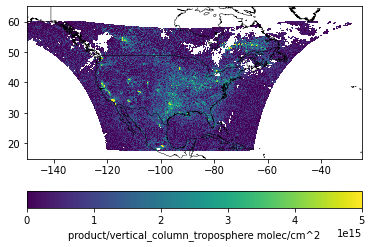

In [ ]:
plotkey = 'product/vertical_column_troposphere'
norm = plt.Normalize(0, 5e15)
fig = plotpaths(filepaths, plotkey=plotkey, norm=norm)

## Animate the TropVCD Map

* Set all slices `visible=False`
* Then, set one to `visible=True`


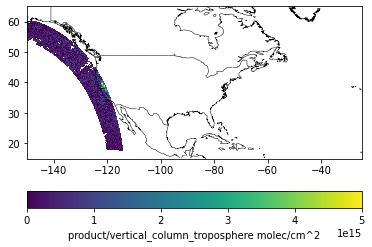

In [ ]:
from IPython.display import clear_output, display
from time import sleep

ax = fig.axes[0]
# Optionally, add a refernece point marker
# ax.plot([-74], [40], marker='+', ls='none', ms=10, mew=2)
# optionally change the normalizers
plt.setp(ax.collections[:-1], norm=norm)
for i in range(10):
  clear_output(wait=True)
  plt.setp(ax.collections[:-1], visible=False)
  ax.collections[i].set_visible(True)
  display(fig)
  sleep(1)
  

## Show full map again

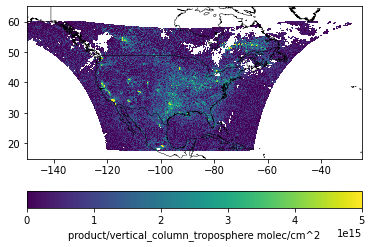

In [ ]:
plt.setp(ax.collections[:-1], visible=True)
fig

## Create a map of tropospheric AMF

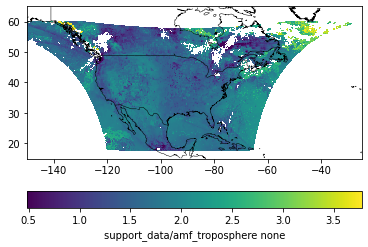

In [ ]:
plotkey = 'support_data/amf_troposphere'
fig = plotpaths(filepaths, plotkey=plotkey, verbose=0)

## Consider using a better map

* The map shown has country boundaries and coastlines using a scale designed for coarse plotting.
* To use a different overlay (e.g., with states) use the `mapkey` to the plotpaths function. Where `<mapkey>` can be frome the options below.

In [ ]:
pycno.downloadable

{'Earth_10x8.cnob': 'https://www.giss.nasa.gov/tools/panoply/overlays/Earth_10x8.cnob',
 'Earth_5x4.cnob': 'https://www.giss.nasa.gov/tools/panoply/overlays/Earth_5x4.cnob',
 'MWDB_Coasts_1.cnob': 'https://www.giss.nasa.gov/tools/panoply/overlays/MWDB_Coasts_1.cnob',
 'MWDB_Coasts_3.cnob': 'https://www.giss.nasa.gov/tools/panoply/overlays/MWDB_Coasts_3.cnob',
 'MWDB_Coasts_Countries_1.cnob': 'https://www.giss.nasa.gov/tools/panoply/overlays/MWDB_Coasts_Countries_1.cnob',
 'MWDB_Coasts_Countries_3.cnob': 'https://www.giss.nasa.gov/tools/panoply/overlays/MWDB_Coasts_Countries_3.cnob',
 'MWDB_Coasts_Lakes_1.cnob': 'https://www.giss.nasa.gov/tools/panoply/overlays/MWDB_Coasts_Lakes_1.cnob',
 'MWDB_Coasts_Lakes_3.cnob': 'https://www.giss.nasa.gov/tools/panoply/overlays/MWDB_Coasts_Lakes_3.cnob',
 'MWDB_Coasts_NA_1.cnob': 'https://www.giss.nasa.gov/tools/panoply/overlays/MWDB_Coasts_NA_1.cnob',
 'MWDB_Coasts_NA_3.cnob': 'https://www.giss.nasa.gov/tools/panoply/overlays/MWDB_Coasts_NA_3.cnob'

Plotting TEMPO_NO2_L2_V01_20200711T182959Z_S010G06.nc


/usr/local/lib/python3.7/dist-packages/pycno/__init__.py:474: UserWarning: Downloading: https://www.giss.nasa.gov/tools/panoply/overlays/MWDB_Coasts_USA_3.cnob to MWDB_Coasts_USA_3.cnob
  warnings.warn('Downloading: ' + url + ' to ' + str(datapatho))


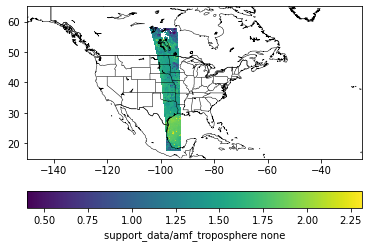

In [ ]:
fig = plotpaths(filepaths[5:6], plotkey='support_data/amf_troposphere', verbose=1, mapkey='MWDB_Coasts_USA_3.cnob')

# Time Series Analysis

## Download multiple times of one grid

* Grids count from the East to the west
* Grid three (G03) contains New York
* Filter all no2filepaths for G03
* Download files that are not already here.

In [ ]:
# For testing use only the 6th pass over the US
filepaths = [path for path in no2filepaths if 'G03' in path]
filepaths

['TEMPO_NO2_L2_V01_20200711T101200Z_S002G03.nc',
 'TEMPO_NO2_L2_V01_20200711T111200Z_S003G03.nc',
 'TEMPO_NO2_L2_V01_20200711T121200Z_S004G03.nc',
 'TEMPO_NO2_L2_V01_20200711T131200Z_S005G03.nc',
 'TEMPO_NO2_L2_V01_20200711T141200Z_S006G03.nc',
 'TEMPO_NO2_L2_V01_20200711T151200Z_S007G03.nc',
 'TEMPO_NO2_L2_V01_20200711T161200Z_S008G03.nc',
 'TEMPO_NO2_L2_V01_20200711T171200Z_S009G03.nc',
 'TEMPO_NO2_L2_V01_20200711T181200Z_S010G03.nc',
 'TEMPO_NO2_L2_V01_20200711T191200Z_S011G03.nc',
 'TEMPO_NO2_L2_V01_20200711T201200Z_S012G03.nc',
 'TEMPO_NO2_L2_V01_20200711T211200Z_S013G03.nc',
 'TEMPO_NO2_L2_V01_20200711T221200Z_S014G03.nc',
 'TEMPO_NO2_L2_V01_20200711T231200Z_S015G03.nc']

In [ ]:
%%time
download(filepaths)

TEMPO_NO2_L2_V01_20200711T101200Z_S002G03.nc ....
TEMPO_NO2_L2_V01_20200711T111200Z_S003G03.nc ....
TEMPO_NO2_L2_V01_20200711T121200Z_S004G03.nc ....
TEMPO_NO2_L2_V01_20200711T131200Z_S005G03.nc ....
TEMPO_NO2_L2_V01_20200711T141200Z_S006G03.nc ....
TEMPO_NO2_L2_V01_20200711T151200Z_S007G03.nc ....
TEMPO_NO2_L2_V01_20200711T161200Z_S008G03.nc ....
TEMPO_NO2_L2_V01_20200711T171200Z_S009G03.nc ....
TEMPO_NO2_L2_V01_20200711T181200Z_S010G03.nc already downloaded.
TEMPO_NO2_L2_V01_20200711T191200Z_S011G03.nc ....
TEMPO_NO2_L2_V01_20200711T201200Z_S012G03.nc ....
TEMPO_NO2_L2_V01_20200711T211200Z_S013G03.nc ....
TEMPO_NO2_L2_V01_20200711T221200Z_S014G03.nc ....
TEMPO_NO2_L2_V01_20200711T231200Z_S015G03.nc ....
CPU times: user 5.96 s, sys: 6.35 s, total: 12.3 s
Wall time: 2min 9s


## Download Observations

### Download Observations

This requires an AQS key. If you did not provide one before, this cell will fail. In that case, run the next cell to load "hard coded" data. If this cell works, you can skip that cell.

In [ ]:
inputf = urlopen(
    'https://aqs.epa.gov/data/api/sampleData/bySite?'
    + f'email={username}&key={userkey}&bdate=20200711&edate=20200711'
    + '&param=42602&state=36&county=005&site=0133'
)
no2json = json.load(inputf)
no2df = pd.DataFrame.from_records(no2json['Data'])

In [ ]:
no2json = json.loads('{"Header": [{"status": "Success", "request_time": "2021-04-12T11:31:42-04:00", "url": "https://aqs.epa.gov/data/api/sampleData/bySite?email=barronh@gmail.com&key=carmelosprey73&bdate=20200711&edate=20200711&param=42602&state=36&county=005&site=0133", "rows": 24}], "Data": [{"state_code": "36", "county_code": "005", "site_number": "0133", "parameter_code": "42602", "poc": 1, "latitude": 40.8679, "longitude": -73.87809, "datum": "WGS84", "parameter": "Nitrogen dioxide (NO2)", "date_local": "2020-07-11", "time_local": "00:00", "date_gmt": "2020-07-11", "time_gmt": "05:00", "sample_measurement": 6.1, "units_of_measure": "Parts per billion", "units_of_measure_code": "008", "sample_duration": "1 HOUR", "sample_duration_code": "1", "sample_frequency": "HOURLY", "detection_limit": 0.04, "uncertainty": null, "qualifier": null, "method_type": "FEM", "method": "Teledyne Model T500U - Cavity Attenuated Phase Shift Spectroscopy", "method_code": "212", "state": "New York", "county": "Bronx", "date_of_last_change": "2020-08-31", "cbsa_code": "35620"}, {"state_code": "36", "county_code": "005", "site_number": "0133", "parameter_code": "42602", "poc": 1, "latitude": 40.8679, "longitude": -73.87809, "datum": "WGS84", "parameter": "Nitrogen dioxide (NO2)", "date_local": "2020-07-11", "time_local": "01:00", "date_gmt": "2020-07-11", "time_gmt": "06:00", "sample_measurement": 6.0, "units_of_measure": "Parts per billion", "units_of_measure_code": "008", "sample_duration": "1 HOUR", "sample_duration_code": "1", "sample_frequency": "HOURLY", "detection_limit": 0.04, "uncertainty": null, "qualifier": null, "method_type": "FEM", "method": "Teledyne Model T500U - Cavity Attenuated Phase Shift Spectroscopy", "method_code": "212", "state": "New York", "county": "Bronx", "date_of_last_change": "2020-08-31", "cbsa_code": "35620"}, {"state_code": "36", "county_code": "005", "site_number": "0133", "parameter_code": "42602", "poc": 1, "latitude": 40.8679, "longitude": -73.87809, "datum": "WGS84", "parameter": "Nitrogen dioxide (NO2)", "date_local": "2020-07-11", "time_local": "02:00", "date_gmt": "2020-07-11", "time_gmt": "07:00", "sample_measurement": 6.1, "units_of_measure": "Parts per billion", "units_of_measure_code": "008", "sample_duration": "1 HOUR", "sample_duration_code": "1", "sample_frequency": "HOURLY", "detection_limit": 0.04, "uncertainty": null, "qualifier": null, "method_type": "FEM", "method": "Teledyne Model T500U - Cavity Attenuated Phase Shift Spectroscopy", "method_code": "212", "state": "New York", "county": "Bronx", "date_of_last_change": "2020-08-31", "cbsa_code": "35620"}, {"state_code": "36", "county_code": "005", "site_number": "0133", "parameter_code": "42602", "poc": 1, "latitude": 40.8679, "longitude": -73.87809, "datum": "WGS84", "parameter": "Nitrogen dioxide (NO2)", "date_local": "2020-07-11", "time_local": "03:00", "date_gmt": "2020-07-11", "time_gmt": "08:00", "sample_measurement": 6.8, "units_of_measure": "Parts per billion", "units_of_measure_code": "008", "sample_duration": "1 HOUR", "sample_duration_code": "1", "sample_frequency": "HOURLY", "detection_limit": 0.04, "uncertainty": null, "qualifier": null, "method_type": "FEM", "method": "Teledyne Model T500U - Cavity Attenuated Phase Shift Spectroscopy", "method_code": "212", "state": "New York", "county": "Bronx", "date_of_last_change": "2020-08-31", "cbsa_code": "35620"}, {"state_code": "36", "county_code": "005", "site_number": "0133", "parameter_code": "42602", "poc": 1, "latitude": 40.8679, "longitude": -73.87809, "datum": "WGS84", "parameter": "Nitrogen dioxide (NO2)", "date_local": "2020-07-11", "time_local": "04:00", "date_gmt": "2020-07-11", "time_gmt": "09:00", "sample_measurement": 9.2, "units_of_measure": "Parts per billion", "units_of_measure_code": "008", "sample_duration": "1 HOUR", "sample_duration_code": "1", "sample_frequency": "HOURLY", "detection_limit": 0.04, "uncertainty": null, "qualifier": null, "method_type": "FEM", "method": "Teledyne Model T500U - Cavity Attenuated Phase Shift Spectroscopy", "method_code": "212", "state": "New York", "county": "Bronx", "date_of_last_change": "2020-08-31", "cbsa_code": "35620"}, {"state_code": "36", "county_code": "005", "site_number": "0133", "parameter_code": "42602", "poc": 1, "latitude": 40.8679, "longitude": -73.87809, "datum": "WGS84", "parameter": "Nitrogen dioxide (NO2)", "date_local": "2020-07-11", "time_local": "05:00", "date_gmt": "2020-07-11", "time_gmt": "10:00", "sample_measurement": 12.9, "units_of_measure": "Parts per billion", "units_of_measure_code": "008", "sample_duration": "1 HOUR", "sample_duration_code": "1", "sample_frequency": "HOURLY", "detection_limit": 0.04, "uncertainty": null, "qualifier": null, "method_type": "FEM", "method": "Teledyne Model T500U - Cavity Attenuated Phase Shift Spectroscopy", "method_code": "212", "state": "New York", "county": "Bronx", "date_of_last_change": "2020-08-31", "cbsa_code": "35620"}, {"state_code": "36", "county_code": "005", "site_number": "0133", "parameter_code": "42602", "poc": 1, "latitude": 40.8679, "longitude": -73.87809, "datum": "WGS84", "parameter": "Nitrogen dioxide (NO2)", "date_local": "2020-07-11", "time_local": "06:00", "date_gmt": "2020-07-11", "time_gmt": "11:00", "sample_measurement": 12.1, "units_of_measure": "Parts per billion", "units_of_measure_code": "008", "sample_duration": "1 HOUR", "sample_duration_code": "1", "sample_frequency": "HOURLY", "detection_limit": 0.04, "uncertainty": null, "qualifier": null, "method_type": "FEM", "method": "Teledyne Model T500U - Cavity Attenuated Phase Shift Spectroscopy", "method_code": "212", "state": "New York", "county": "Bronx", "date_of_last_change": "2020-08-31", "cbsa_code": "35620"}, {"state_code": "36", "county_code": "005", "site_number": "0133", "parameter_code": "42602", "poc": 1, "latitude": 40.8679, "longitude": -73.87809, "datum": "WGS84", "parameter": "Nitrogen dioxide (NO2)", "date_local": "2020-07-11", "time_local": "07:00", "date_gmt": "2020-07-11", "time_gmt": "12:00", "sample_measurement": 9.4, "units_of_measure": "Parts per billion", "units_of_measure_code": "008", "sample_duration": "1 HOUR", "sample_duration_code": "1", "sample_frequency": "HOURLY", "detection_limit": 0.04, "uncertainty": null, "qualifier": null, "method_type": "FEM", "method": "Teledyne Model T500U - Cavity Attenuated Phase Shift Spectroscopy", "method_code": "212", "state": "New York", "county": "Bronx", "date_of_last_change": "2020-08-31", "cbsa_code": "35620"}, {"state_code": "36", "county_code": "005", "site_number": "0133", "parameter_code": "42602", "poc": 1, "latitude": 40.8679, "longitude": -73.87809, "datum": "WGS84", "parameter": "Nitrogen dioxide (NO2)", "date_local": "2020-07-11", "time_local": "08:00", "date_gmt": "2020-07-11", "time_gmt": "13:00", "sample_measurement": 6.3, "units_of_measure": "Parts per billion", "units_of_measure_code": "008", "sample_duration": "1 HOUR", "sample_duration_code": "1", "sample_frequency": "HOURLY", "detection_limit": 0.04, "uncertainty": null, "qualifier": null, "method_type": "FEM", "method": "Teledyne Model T500U - Cavity Attenuated Phase Shift Spectroscopy", "method_code": "212", "state": "New York", "county": "Bronx", "date_of_last_change": "2020-08-31", "cbsa_code": "35620"}, {"state_code": "36", "county_code": "005", "site_number": "0133", "parameter_code": "42602", "poc": 1, "latitude": 40.8679, "longitude": -73.87809, "datum": "WGS84", "parameter": "Nitrogen dioxide (NO2)", "date_local": "2020-07-11", "time_local": "09:00", "date_gmt": "2020-07-11", "time_gmt": "14:00", "sample_measurement": 5.1, "units_of_measure": "Parts per billion", "units_of_measure_code": "008", "sample_duration": "1 HOUR", "sample_duration_code": "1", "sample_frequency": "HOURLY", "detection_limit": 0.04, "uncertainty": null, "qualifier": null, "method_type": "FEM", "method": "Teledyne Model T500U - Cavity Attenuated Phase Shift Spectroscopy", "method_code": "212", "state": "New York", "county": "Bronx", "date_of_last_change": "2020-08-31", "cbsa_code": "35620"}, {"state_code": "36", "county_code": "005", "site_number": "0133", "parameter_code": "42602", "poc": 1, "latitude": 40.8679, "longitude": -73.87809, "datum": "WGS84", "parameter": "Nitrogen dioxide (NO2)", "date_local": "2020-07-11", "time_local": "10:00", "date_gmt": "2020-07-11", "time_gmt": "15:00", "sample_measurement": 4.8, "units_of_measure": "Parts per billion", "units_of_measure_code": "008", "sample_duration": "1 HOUR", "sample_duration_code": "1", "sample_frequency": "HOURLY", "detection_limit": 0.04, "uncertainty": null, "qualifier": null, "method_type": "FEM", "method": "Teledyne Model T500U - Cavity Attenuated Phase Shift Spectroscopy", "method_code": "212", "state": "New York", "county": "Bronx", "date_of_last_change": "2020-08-31", "cbsa_code": "35620"}, {"state_code": "36", "county_code": "005", "site_number": "0133", "parameter_code": "42602", "poc": 1, "latitude": 40.8679, "longitude": -73.87809, "datum": "WGS84", "parameter": "Nitrogen dioxide (NO2)", "date_local": "2020-07-11", "time_local": "11:00", "date_gmt": "2020-07-11", "time_gmt": "16:00", "sample_measurement": 2.9, "units_of_measure": "Parts per billion", "units_of_measure_code": "008", "sample_duration": "1 HOUR", "sample_duration_code": "1", "sample_frequency": "HOURLY", "detection_limit": 0.04, "uncertainty": null, "qualifier": null, "method_type": "FEM", "method": "Teledyne Model T500U - Cavity Attenuated Phase Shift Spectroscopy", "method_code": "212", "state": "New York", "county": "Bronx", "date_of_last_change": "2020-08-31", "cbsa_code": "35620"}, {"state_code": "36", "county_code": "005", "site_number": "0133", "parameter_code": "42602", "poc": 1, "latitude": 40.8679, "longitude": -73.87809, "datum": "WGS84", "parameter": "Nitrogen dioxide (NO2)", "date_local": "2020-07-11", "time_local": "12:00", "date_gmt": "2020-07-11", "time_gmt": "17:00", "sample_measurement": 2.9, "units_of_measure": "Parts per billion", "units_of_measure_code": "008", "sample_duration": "1 HOUR", "sample_duration_code": "1", "sample_frequency": "HOURLY", "detection_limit": 0.04, "uncertainty": null, "qualifier": null, "method_type": "FEM", "method": "Teledyne Model T500U - Cavity Attenuated Phase Shift Spectroscopy", "method_code": "212", "state": "New York", "county": "Bronx", "date_of_last_change": "2020-08-31", "cbsa_code": "35620"}, {"state_code": "36", "county_code": "005", "site_number": "0133", "parameter_code": "42602", "poc": 1, "latitude": 40.8679, "longitude": -73.87809, "datum": "WGS84", "parameter": "Nitrogen dioxide (NO2)", "date_local": "2020-07-11", "time_local": "13:00", "date_gmt": "2020-07-11", "time_gmt": "18:00", "sample_measurement": 4.1, "units_of_measure": "Parts per billion", "units_of_measure_code": "008", "sample_duration": "1 HOUR", "sample_duration_code": "1", "sample_frequency": "HOURLY", "detection_limit": 0.04, "uncertainty": null, "qualifier": null, "method_type": "FEM", "method": "Teledyne Model T500U - Cavity Attenuated Phase Shift Spectroscopy", "method_code": "212", "state": "New York", "county": "Bronx", "date_of_last_change": "2020-08-31", "cbsa_code": "35620"}, {"state_code": "36", "county_code": "005", "site_number": "0133", "parameter_code": "42602", "poc": 1, "latitude": 40.8679, "longitude": -73.87809, "datum": "WGS84", "parameter": "Nitrogen dioxide (NO2)", "date_local": "2020-07-11", "time_local": "14:00", "date_gmt": "2020-07-11", "time_gmt": "19:00", "sample_measurement": 4.4, "units_of_measure": "Parts per billion", "units_of_measure_code": "008", "sample_duration": "1 HOUR", "sample_duration_code": "1", "sample_frequency": "HOURLY", "detection_limit": 0.04, "uncertainty": null, "qualifier": null, "method_type": "FEM", "method": "Teledyne Model T500U - Cavity Attenuated Phase Shift Spectroscopy", "method_code": "212", "state": "New York", "county": "Bronx", "date_of_last_change": "2020-08-31", "cbsa_code": "35620"}, {"state_code": "36", "county_code": "005", "site_number": "0133", "parameter_code": "42602", "poc": 1, "latitude": 40.8679, "longitude": -73.87809, "datum": "WGS84", "parameter": "Nitrogen dioxide (NO2)", "date_local": "2020-07-11", "time_local": "15:00", "date_gmt": "2020-07-11", "time_gmt": "20:00", "sample_measurement": 3.9, "units_of_measure": "Parts per billion", "units_of_measure_code": "008", "sample_duration": "1 HOUR", "sample_duration_code": "1", "sample_frequency": "HOURLY", "detection_limit": 0.04, "uncertainty": null, "qualifier": null, "method_type": "FEM", "method": "Teledyne Model T500U - Cavity Attenuated Phase Shift Spectroscopy", "method_code": "212", "state": "New York", "county": "Bronx", "date_of_last_change": "2020-08-31", "cbsa_code": "35620"}, {"state_code": "36", "county_code": "005", "site_number": "0133", "parameter_code": "42602", "poc": 1, "latitude": 40.8679, "longitude": -73.87809, "datum": "WGS84", "parameter": "Nitrogen dioxide (NO2)", "date_local": "2020-07-11", "time_local": "16:00", "date_gmt": "2020-07-11", "time_gmt": "21:00", "sample_measurement": 3.5, "units_of_measure": "Parts per billion", "units_of_measure_code": "008", "sample_duration": "1 HOUR", "sample_duration_code": "1", "sample_frequency": "HOURLY", "detection_limit": 0.04, "uncertainty": null, "qualifier": null, "method_type": "FEM", "method": "Teledyne Model T500U - Cavity Attenuated Phase Shift Spectroscopy", "method_code": "212", "state": "New York", "county": "Bronx", "date_of_last_change": "2020-08-31", "cbsa_code": "35620"}, {"state_code": "36", "county_code": "005", "site_number": "0133", "parameter_code": "42602", "poc": 1, "latitude": 40.8679, "longitude": -73.87809, "datum": "WGS84", "parameter": "Nitrogen dioxide (NO2)", "date_local": "2020-07-11", "time_local": "17:00", "date_gmt": "2020-07-11", "time_gmt": "22:00", "sample_measurement": 5.2, "units_of_measure": "Parts per billion", "units_of_measure_code": "008", "sample_duration": "1 HOUR", "sample_duration_code": "1", "sample_frequency": "HOURLY", "detection_limit": 0.04, "uncertainty": null, "qualifier": null, "method_type": "FEM", "method": "Teledyne Model T500U - Cavity Attenuated Phase Shift Spectroscopy", "method_code": "212", "state": "New York", "county": "Bronx", "date_of_last_change": "2020-08-31", "cbsa_code": "35620"}, {"state_code": "36", "county_code": "005", "site_number": "0133", "parameter_code": "42602", "poc": 1, "latitude": 40.8679, "longitude": -73.87809, "datum": "WGS84", "parameter": "Nitrogen dioxide (NO2)", "date_local": "2020-07-11", "time_local": "18:00", "date_gmt": "2020-07-11", "time_gmt": "23:00", "sample_measurement": 6.1, "units_of_measure": "Parts per billion", "units_of_measure_code": "008", "sample_duration": "1 HOUR", "sample_duration_code": "1", "sample_frequency": "HOURLY", "detection_limit": 0.04, "uncertainty": null, "qualifier": null, "method_type": "FEM", "method": "Teledyne Model T500U - Cavity Attenuated Phase Shift Spectroscopy", "method_code": "212", "state": "New York", "county": "Bronx", "date_of_last_change": "2020-08-31", "cbsa_code": "35620"}, {"state_code": "36", "county_code": "005", "site_number": "0133", "parameter_code": "42602", "poc": 1, "latitude": 40.8679, "longitude": -73.87809, "datum": "WGS84", "parameter": "Nitrogen dioxide (NO2)", "date_local": "2020-07-11", "time_local": "19:00", "date_gmt": "2020-07-12", "time_gmt": "00:00", "sample_measurement": 16.5, "units_of_measure": "Parts per billion", "units_of_measure_code": "008", "sample_duration": "1 HOUR", "sample_duration_code": "1", "sample_frequency": "HOURLY", "detection_limit": 0.04, "uncertainty": null, "qualifier": null, "method_type": "FEM", "method": "Teledyne Model T500U - Cavity Attenuated Phase Shift Spectroscopy", "method_code": "212", "state": "New York", "county": "Bronx", "date_of_last_change": "2020-08-31", "cbsa_code": "35620"}, {"state_code": "36", "county_code": "005", "site_number": "0133", "parameter_code": "42602", "poc": 1, "latitude": 40.8679, "longitude": -73.87809, "datum": "WGS84", "parameter": "Nitrogen dioxide (NO2)", "date_local": "2020-07-11", "time_local": "20:00", "date_gmt": "2020-07-12", "time_gmt": "01:00", "sample_measurement": 20.5, "units_of_measure": "Parts per billion", "units_of_measure_code": "008", "sample_duration": "1 HOUR", "sample_duration_code": "1", "sample_frequency": "HOURLY", "detection_limit": 0.04, "uncertainty": null, "qualifier": null, "method_type": "FEM", "method": "Teledyne Model T500U - Cavity Attenuated Phase Shift Spectroscopy", "method_code": "212", "state": "New York", "county": "Bronx", "date_of_last_change": "2020-08-31", "cbsa_code": "35620"}, {"state_code": "36", "county_code": "005", "site_number": "0133", "parameter_code": "42602", "poc": 1, "latitude": 40.8679, "longitude": -73.87809, "datum": "WGS84", "parameter": "Nitrogen dioxide (NO2)", "date_local": "2020-07-11", "time_local": "21:00", "date_gmt": "2020-07-12", "time_gmt": "02:00", "sample_measurement": 19.6, "units_of_measure": "Parts per billion", "units_of_measure_code": "008", "sample_duration": "1 HOUR", "sample_duration_code": "1", "sample_frequency": "HOURLY", "detection_limit": 0.04, "uncertainty": null, "qualifier": null, "method_type": "FEM", "method": "Teledyne Model T500U - Cavity Attenuated Phase Shift Spectroscopy", "method_code": "212", "state": "New York", "county": "Bronx", "date_of_last_change": "2020-08-31", "cbsa_code": "35620"}, {"state_code": "36", "county_code": "005", "site_number": "0133", "parameter_code": "42602", "poc": 1, "latitude": 40.8679, "longitude": -73.87809, "datum": "WGS84", "parameter": "Nitrogen dioxide (NO2)", "date_local": "2020-07-11", "time_local": "22:00", "date_gmt": "2020-07-12", "time_gmt": "03:00", "sample_measurement": 18.0, "units_of_measure": "Parts per billion", "units_of_measure_code": "008", "sample_duration": "1 HOUR", "sample_duration_code": "1", "sample_frequency": "HOURLY", "detection_limit": 0.04, "uncertainty": null, "qualifier": null, "method_type": "FEM", "method": "Teledyne Model T500U - Cavity Attenuated Phase Shift Spectroscopy", "method_code": "212", "state": "New York", "county": "Bronx", "date_of_last_change": "2020-08-31", "cbsa_code": "35620"}, {"state_code": "36", "county_code": "005", "site_number": "0133", "parameter_code": "42602", "poc": 1, "latitude": 40.8679, "longitude": -73.87809, "datum": "WGS84", "parameter": "Nitrogen dioxide (NO2)", "date_local": "2020-07-11", "time_local": "23:00", "date_gmt": "2020-07-12", "time_gmt": "04:00", "sample_measurement": 7.3, "units_of_measure": "Parts per billion", "units_of_measure_code": "008", "sample_duration": "1 HOUR", "sample_duration_code": "1", "sample_frequency": "HOURLY", "detection_limit": 0.04, "uncertainty": null, "qualifier": null, "method_type": "FEM", "method": "Teledyne Model T500U - Cavity Attenuated Phase Shift Spectroscopy", "method_code": "212", "state": "New York", "county": "Bronx", "date_of_last_change": "2020-08-31", "cbsa_code": "35620"}]}')
no2df = pd.DataFrame.from_records(no2json['Data'])

### Load a Metadata row

In [ ]:
# Use the first row as meta-data
metarow = no2df.loc[0].drop('sample_measurement')
metarow

state_code                                                              36
county_code                                                            005
site_number                                                           0133
parameter_code                                                       42602
poc                                                                      1
latitude                                                           40.8679
longitude                                                         -73.8781
datum                                                                WGS84
parameter                                           Nitrogen dioxide (NO2)
date_local                                                      2020-07-11
time_local                                                           00:00
date_gmt                                                        2020-07-11
time_gmt                                                             05:00
units_of_measure         

In [ ]:
no2df['datetime_gmt'] = pd.to_datetime(no2df['date_gmt'] + 'T' + no2df['time_gmt'])
mlat = no2df.loc[0, 'latitude']
mlon = no2df.loc[0, 'longitude']

## Open each scan file

In [ ]:
tsfs = [Dataset(filepath) for filepath in filepaths]
reprf = tsfs[0]

## Index the monitor location


In [ ]:
dlat = (reprf['geolocation/latitude'][:] - mlat)
dlon = (reprf['geolocation/longitude'][:] - mlon)
d = (dlat**2 + dlon**2)**.5
mj, mi = np.unravel_index(d.argmin(), d.shape)
print('degrees from monitor', d[mj, mi])

degrees from monitor 0.014858966


## Create arrays at the monitor

* By default, we are choosing the nearest pixel.
* Alternatively, we could choose a matrix around the pixel.
* After running the standard approach, come back and rerun for a matrix.
  * replace `mj` with `mj-1:mj+2`
  * replace `mi` with `mi-1:mi+2`
  * How does this change the agreement at the monitor?

In [ ]:
vcd = np.ma.array([tsf['product/vertical_column_troposphere'][mj, mi].mean() for tsf in tsfs])
vcd = np.ma.array([tsf['product/vertical_column_troposphere'][mj - 1:mj+2, mi-1:mi+2].mean() for tsf in tsfs])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  


In [ ]:
lat = np.ma.array([tsf['geolocation/latitude'][mj, mi] for tsf in tsfs])
lon = np.ma.array([tsf['geolocation/longitude'][mj, mi] for tsf in tsfs])
time = np.ma.array([tsf['geolocation/time'][mj] for tsf in tsfs])

In [ ]:
# Convert time as an integer into time objects
t = cftime.num2pydate(time, tsfs[0]['geolocation/time'].units)

## Plot the time series

* Plot VCD as a function of time
* Add a secondary axis for surface measurments.
* Plot NO2 ppb from the monitor
* Beautify the plots
  * add a legend
  * add a title using metadata
  * add labels

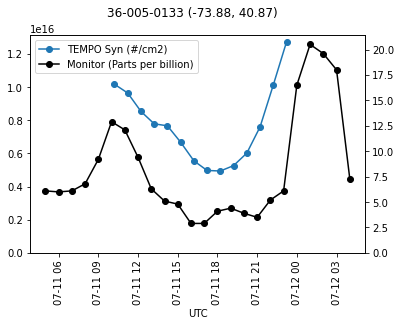

In [ ]:
fig, satax = plt.subplots(1, 1)
monax = plt.twinx()

ltempo, = satax.plot(t, vcd, marker='o', label='TEMPO Syn (#/cm2)')
lmon, = monax.plot(no2df['datetime_gmt'], no2df['sample_measurement'], c='k', marker='o', label=f"Monitor ({metarow['units_of_measure']})")

titlestr = '{state_code:>2s}-{county_code:>3s}-{site_number:>4s} ({longitude:.2f}, {latitude:.2f})'.format(**metarow)
fig.suptitle(titlestr)
plt.setp(satax, ylim=(0, None), xlabel='UTC')
plt.setp(satax.get_xticklabels(), rotation=90)
plt.setp(monax, ylim=(0, None))#, xlim=(t[0], t[-1]))
plt.legend([ltempo, lmon], [ltempo.get_label(), lmon.get_label()]);

# Advanced Exercises

* If you finished the exercises above, we have some recommendations for you.
* These are largely adaptations of the previous exercises.
  * First, do the same analyses except for formaldehyde.
  * Second, repeat the time-series NO2 analysis for your own monitor.
  * Third, repeat the time-series analysis for the NO2:HCHO ratio.

## Repeat for formaldehyde

* Start over at "Create a TEMPO Map for one Scan
  * In "Subset filepaths" change the subset of file so that the path must contain HCHO instead of NO2
  * In "Display File Structure", note the new name for the VCD.
  * In "Create a map of tropospheric vertical column density", replace the plotkey with the new VCD name
* Start over at "Time Series Analysis"
  * In "Download multiple times of one grid", change the filter to contain HCHO instead of NO2.
  * In "Create arrays at the monitor", replace the VCD variable name.
  * Change the AQS monitor to 36-81-0133 and the pollutant to formaldehyde (43502) instead of nitrogen dioxide (42602)
  * Also, there is no valid data in the county on that day. Use 2013-07-03 as a surrogate.

### If you have a login, use this cell

* This cell will only work if username and userkey were provided.
* If it fails, run the next cell to load archived data.

In [ ]:
inputf = urlopen(
    'https://aqs.epa.gov/data/api/sampleData/bySite?'
    + f'email={username}&key={userkey}&bdate=20200711&edate=20200711'
    + '&param=43502&state=36&county=005&site=0133'
)
hchojson = json.load(inputf)
hchodf = pd.DataFrame.from_records(hchojson['Data'])

In [ ]:
hchojson = json.loads('{"Header": [{"status": "Success", "request_time": "2021-04-12T11:31:23-04:00", "url": "https://aqs.epa.gov/data/api/sampleData/bySite?email=barronh@gmail.com&key=carmelosprey73&bdate=20200711&edate=20200711&param=43502&state=36&county=005&site=0133", "rows": 3}], "Data": [{"state_code": "36", "county_code": "005", "site_number": "0133", "parameter_code": "43502", "poc": 8, "latitude": 40.8679, "longitude": -73.87809, "datum": "WGS84", "parameter": "Formaldehyde", "date_local": "2020-07-11", "time_local": "04:00", "date_gmt": "2020-07-11", "time_gmt": "09:00", "sample_measurement": 2.7, "units_of_measure": "Parts per billion Carbon", "units_of_measure_code": "078", "sample_duration": "8 HOUR", "sample_duration_code": "5", "sample_frequency": "EVERY 3RD DAY", "detection_limit": 0.02, "uncertainty": null, "qualifier": null, "method_type": "Non-FRM", "method": "SILICA-DNPH-CART-KI O3 SCRUB - HPLC ULTRAVIOLET ABSORPTION", "method_code": "202", "state": "New York", "county": "Bronx", "date_of_last_change": "2020-10-08", "cbsa_code": "35620"}, {"state_code": "36", "county_code": "005", "site_number": "0133", "parameter_code": "43502", "poc": 8, "latitude": 40.8679, "longitude": -73.87809, "datum": "WGS84", "parameter": "Formaldehyde", "date_local": "2020-07-11", "time_local": "12:00", "date_gmt": "2020-07-11", "time_gmt": "17:00", "sample_measurement": 3.0, "units_of_measure": "Parts per billion Carbon", "units_of_measure_code": "078", "sample_duration": "8 HOUR", "sample_duration_code": "5", "sample_frequency": "EVERY 3RD DAY", "detection_limit": 0.02, "uncertainty": null, "qualifier": null, "method_type": "Non-FRM", "method": "SILICA-DNPH-CART-KI O3 SCRUB - HPLC ULTRAVIOLET ABSORPTION", "method_code": "202", "state": "New York", "county": "Bronx", "date_of_last_change": "2020-10-08", "cbsa_code": "35620"}, {"state_code": "36", "county_code": "005", "site_number": "0133", "parameter_code": "43502", "poc": 8, "latitude": 40.8679, "longitude": -73.87809, "datum": "WGS84", "parameter": "Formaldehyde", "date_local": "2020-07-11", "time_local": "20:00", "date_gmt": "2020-07-12", "time_gmt": "01:00", "sample_measurement": 1.9, "units_of_measure": "Parts per billion Carbon", "units_of_measure_code": "078", "sample_duration": "8 HOUR", "sample_duration_code": "5", "sample_frequency": "EVERY 3RD DAY", "detection_limit": 0.02, "uncertainty": null, "qualifier": null, "method_type": "Non-FRM", "method": "SILICA-DNPH-CART-KI O3 SCRUB - HPLC ULTRAVIOLET ABSORPTION", "method_code": "202", "state": "New York", "county": "Bronx", "date_of_last_change": "2020-10-08", "cbsa_code": "35620"}]}')
hchodf = pd.DataFrame.from_records(hchojson['Data'])

## Redo the analysis for a monitor of interest to you

* This step will require a valid AQS username and key.
* Use EPA's air quality monitor interactive map to find an NO2 monitor of interest to you
  * https://www.epa.gov/outdoor-air-quality-data/interactive-map-air-quality-monitors
  * Choose the "Active NO2" layer and find a monitor with data in 2013-07-01
* Determine which grid G?? the monitor is in.
  * Hint, look at the bounds of each grid for the full scan.
  * Find the one that has the monitor in it.
  * Optionally, add a marker on the map in the animation. Then watch the animation and note when it is over the marker.
* Repeat "Time Series Analysis" at that monitor.
* Try again for a formaldehyde monitor

## Develop an NO2:HCHO satellite relationshiop for a specific monitor

* Take the elements from "Time Series Analysis" and perform for both NO2 and HCHO. 
* Then, plot the NO2:HCHO ratio. 
* Jin et al. (https://dx.doi.org/10.1021/acs.est.9b07785)
  * Ratio of OMI NO2 and HCHO (1:30pm LST overpass; ~18:30Z)
  * Optimal ratio in New York 3.3 (2.9-3.8)
  * NOx-limited above; VOC-limited below
* Finally, consider the fraction of NO2 in the PBL as a function of time-of-day.
  * How do you expec the ratio to change?
  * Can you improve on the simple ratio?
  

In [ ]:
%%time
vcds = {}
for spctag, prodkey in [
  ('NO2', 'product/vertical_column_troposphere'),
  ('HCHO', 'product/vertical_column')
]:
  mypaths = [path for path in allfilepaths if 'G03' in path and spctag in path]
  download(mypaths)
  tsfs = [Dataset(path) for path in mypaths]
  vcds[spctag] = np.ma.array([tsf[prodkey][mj, mi] for tsf in tsfs])

TEMPO_NO2_L2_V01_20200711T101200Z_S002G03.nc already downloaded.
TEMPO_NO2_L2_V01_20200711T111200Z_S003G03.nc already downloaded.
TEMPO_NO2_L2_V01_20200711T121200Z_S004G03.nc already downloaded.
TEMPO_NO2_L2_V01_20200711T131200Z_S005G03.nc already downloaded.
TEMPO_NO2_L2_V01_20200711T141200Z_S006G03.nc already downloaded.
TEMPO_NO2_L2_V01_20200711T151200Z_S007G03.nc already downloaded.
TEMPO_NO2_L2_V01_20200711T161200Z_S008G03.nc already downloaded.
TEMPO_NO2_L2_V01_20200711T171200Z_S009G03.nc already downloaded.
TEMPO_NO2_L2_V01_20200711T181200Z_S010G03.nc already downloaded.
TEMPO_NO2_L2_V01_20200711T191200Z_S011G03.nc already downloaded.
TEMPO_NO2_L2_V01_20200711T201200Z_S012G03.nc already downloaded.
TEMPO_NO2_L2_V01_20200711T211200Z_S013G03.nc already downloaded.
TEMPO_NO2_L2_V01_20200711T221200Z_S014G03.nc already downloaded.
TEMPO_NO2_L2_V01_20200711T231200Z_S015G03.nc already downloaded.
TEMPO_HCHO_L2_V01_20200711T101200Z_S002G03.nc ...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  if __name__ == '__main__':


.
TEMPO_HCHO_L2_V01_20200711T111200Z_S003G03.nc ....
TEMPO_HCHO_L2_V01_20200711T121200Z_S004G03.nc ....
TEMPO_HCHO_L2_V01_20200711T131200Z_S005G03.nc ....
TEMPO_HCHO_L2_V01_20200711T141200Z_S006G03.nc ....
TEMPO_HCHO_L2_V01_20200711T151200Z_S007G03.nc ....
TEMPO_HCHO_L2_V01_20200711T161200Z_S008G03.nc ....
TEMPO_HCHO_L2_V01_20200711T171200Z_S009G03.nc ....
TEMPO_HCHO_L2_V01_20200711T181200Z_S010G03.nc ....
TEMPO_HCHO_L2_V01_20200711T191200Z_S011G03.nc ....
TEMPO_HCHO_L2_V01_20200711T201200Z_S012G03.nc ....
TEMPO_HCHO_L2_V01_20200711T211200Z_S013G03.nc ....
TEMPO_HCHO_L2_V01_20200711T221200Z_S014G03.nc ....
TEMPO_HCHO_L2_V01_20200711T231200Z_S015G03.nc ....
CPU times: user 5.65 s, sys: 4.51 s, total: 10.2 s
Wall time: 1min 43s


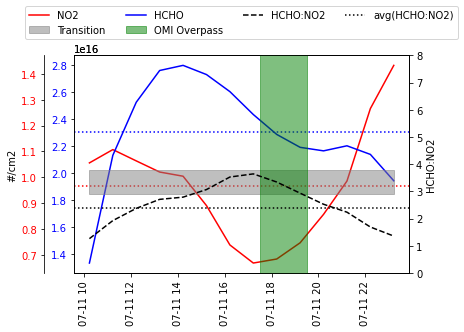

In [ ]:
fig, nax = plt.subplots(1, 1)
fax = plt.twinx()
rax = plt.twinx()

ln, = nax.plot(t, vcds['NO2'], label='NO2', c='r')
nax.spines['left'].set_position(('outward', 30))
nax.set_ylabel('')
lf, = fax.plot(t, vcds['HCHO'], label='HCHO', c='b')
lr, = rax.plot(t, vcds['HCHO']/vcds['NO2'], ls='--', c='k', label='HCHO:NO2')
lnd = nax.axhline(vcds['NO2'].mean(), label='avg(NO2)', ls=':', c='r')
lfd = fax.axhline(vcds['HCHO'].mean(), label='avg(HCHO)', ls=':', c='b')
lrd = rax.axhline(vcds['HCHO'].mean() / vcds['NO2'].mean(), label='avg(HCHO:NO2)', ls=':', c='k')

transitionp = rax.fill_between([t[0], t[-1]], y1=2.9, y2=3.8, color='grey', alpha=.5, label='Transition')
omioverpassts = cftime.num2pydate([-1, 1], 'hours since 2020-07-11 13:30-0500')
rax.set_ylim(0, 8)
overpassp = rax.fill_betweenx(x1=omioverpassts[0], x2=omioverpassts[1], y=rax.get_ylim(), color='g', alpha=.5, label='OMI Overpass')

plt.setp(nax.get_xticklabels(), rotation=90)
plt.setp(nax.get_yticklabels(), c='r')
nax.set_ylabel('#/cm2')
rax.set_ylabel('HCHO:NO2')
plt.setp(fax.get_yticklabels(), c='b')
lines = [ln, transitionp, lf, overpassp, lr, lrd]
plt.legend(lines, [l.get_label() for l in lines], ncol=4, bbox_to_anchor=(.5, 1.15), loc='center');